In [108]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.style as style, matplotlib.colors as colors
import random
from scipy.stats import norm
%matplotlib inline
style.use("classic")
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 93
plt.rcParams["figure.figsize"] = (6,5)

In [40]:
class POI(object):
    n_pois = 0
    
    def __init__(self, uid):
        POI.n_pois += 1
        self.history = []
        self.poid = POI.n_pois
        self.mappers = set([uid])
        self.n_edits = 0
        self.n_tags = 0
        
    def n_mappers(self):
        return len(self.mappers)

    def describe(self):
        return self.__dict__



class Mapper(object):
    n_mappers = 0
    mapathon = None
    #window = 10
    
    
    def __init__(self, p, s, p_action, p_modify, state):
        self.p = p
        self.s = s
        self.p_action = p_action
        self.p_modify = p_modify
        self.history = []
        Mapper.n_mappers += 1
        self.uid = Mapper.n_mappers
        self.n = 0
        self.origin = state
        
    def describe(self):
        return self.__dict__
  
        
    def membership(self, show=True):
        if self.n < Mapper.window:
            raise ValueError("This mapper has not interacted enough yet. (n={})".format(Mapper.window))
        else:
            self.ac = pd.Series([edit["action"] for edit in self.history ]).value_counts().idxmax()
            self.mc = pd.Series([edit["mod_type"] for edit in self.history]).value_counts().idxmax()
            self.ec = "A" if self.n > 13 else "B"#toy function
            #print(self.ac, self.mc, self.ec) if show else None
    def change_priors(self, del_weight=0.95):
        ints_action = np.random.randint(2,1000, size=3)
        ints_modify = np.random.randint(2,1000, size=4)
        ints_action[-1] = ints_action[-1]*del_weight
        self.p_action = list(ints_action/ints_action.sum())
        self.modify = list(ints_modify/ints_modify.sum())
        
    def action(self, environment, state):
        visited = [_["poid"] for _ in self.history ]
        visited_coords = [_ for _ in environment if environment[_] != None and environment[_].poid in visited]
        states = [_["state"] for _ in self.history]
        s = 0 if len(visited_coords) ==0 else self.s
        occupied = [i for i in environment if environment[i] != None]
        not_occupied = [i for i in environment if environment[i] == None]
        if np.random.binomial(1, self.p) == 1:  
            self.n += 1
            #Assumptions about priors
            action_type = np.random.choice(a=["create","modify", "delete"], p=self.p_action) if len(occupied) > 1 else "create"
            mod_type = np.random.choice(a=["tag_ch", "tag_del", "tag_add", "pos_ch"], p=self.p_modify) if action_type == "modify" else None
            if np.random.binomial(1, s) != 1:
                if action_type != "create":
                    env_choice = random.choice(occupied)
                else:
                    if len(not_occupied) > 0:
                        env_choice = random.choice(not_occupied)
                    else:
                        action_type = random.choice(["modify","delete"])
                        env_choice = random.choice(occupied)
                        
                
                    #env_choice = random.choice(not_occupied) if action_type== "create" else random.choice(occupied)
            else:
                #print("a")
                
                random_visited = random.choice(visited_coords)
                coord = random_visited
                for c in [(random_visited[0]+1, random_visited[1]),
                                           (random_visited[0]-1, random_visited[1]),
                                           (random_visited[0], random_visited[1]-1),
                                           (random_visited[0], random_visited[1]+1)]:
                    if c in environment:
                        env_choice = c
                        
            #print("b")
                

            if action_type == "create":
                poi = POI(self.uid)
                environment[env_choice] = poi
            elif action_type =="delete":
                poi = environment[env_choice]
                if poi==None:
                    poi = environment[random.choice(visited_coords)]
                poi.mappers.add(self.uid)
                environment[env_choice] = None
            elif action_type == "modify":
                poi = environment[env_choice]
                if poi==None:
                    poi = environment[random.choice(visited_coords)]
                poi.mappers.add(self.uid)
                poi.n_edits += 1
                if mod_type == "tag_add":
                    poi.n_tags += 1
                elif mod_type == "tag_del":
                    poi.n_tags -= 1      
            #print(state, action_type, env_choice)
            self.history.append({ "action" : action_type, "mod_type" : mod_type, "poid" : poi.poid, "state" : state })
            poi.history.append({ "action" : action_type, "mod_type" : mod_type, "uid" : self.uid, "state" : state  })

        else:
            return

    @classmethod 
    def simulate_mapathon(cls, kind):
        cls.mapathon = kind
        pass
        
        
def map_state(environment):
    x = [i[0] for i in environment.keys()]
    y = [i[1] for i in environment.keys()]
    occupied_x = [i[0] for i in environment if environment[i] != None]
    occupied_y = [i[1] for i in environment if environment[i] != None]
    ax = plt.scatter(x,y,s=8.9)
    plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.yticks(np.arange(min(y), max(y)+1, 1.0))
    plt.scatter(occupied_x, occupied_y, color="red")
    plt.axis("off")

In [41]:
def sim(n_mappers, new_mapper_prob, p,
            p_action, p_modify,
            s,stationary,grid_dim=10):
    # Simulate
    state=0
    Mapper.n_mappers = 0
    POI.n_pois = 0
    #Instantiate Environment and mappers
    environment = {(i, j) : None for i in range(1, grid_dim+1) for j in range(1, grid_dim+1)}
    mappers = [Mapper(p,s,p_action,p_modify,state) for i in range(n_mappers)]
    #Run
    while None in list(environment.values()):
        state += 1
        # new mappers can potentially join 
        if np.random.binomial(1, new_mapper_prob) == 1:
            new = Mapper(p,s,p_action,p_modify,state)
            new.change_priors()
            mappers.append(new)
        for mapper in mappers:
            if not stationary and state!=0:
                mapper.change_priors()      
            mapper.action(environment, state)
               
    data = []
    for mapper in mappers:
        data += mapper.history
    T = state
    df = pd.DataFrame(data).sort_values(by="state")
    unique_pois = df.poid.nunique()
    df["create"] = df.action.apply(lambda x : 1 if x== "create" else 0)
    df["modify"] = df.action.apply(lambda x : 1 if x== "modify" else 0)
    df["delete"] = df.action.apply(lambda x : 1 if x== "delete" else 0)
    del df["action"]

    df["pos_ch"] = df.mod_type.apply(lambda x : 1 if x== "pos_ch" else 0)
    df["tag_add"] = df.mod_type.apply(lambda x : 1 if x== "tag_add" else 0)
    df["tag_del"] = df.mod_type.apply(lambda x : 1 if x== "tag_del" else 0)
    df["tag_ch"] = df.mod_type.apply(lambda x : 1 if x== "tag_ch" else 0)
    del df["mod_type"]
    del df["poid"]
    #map_state(environment)
    df = df.groupby("state").sum()
    df = df.reindex(list(range(1, T+1))).replace(np.nan, 0)
    return df, T, unique_pois, len(mappers)

### Simulation Example Run

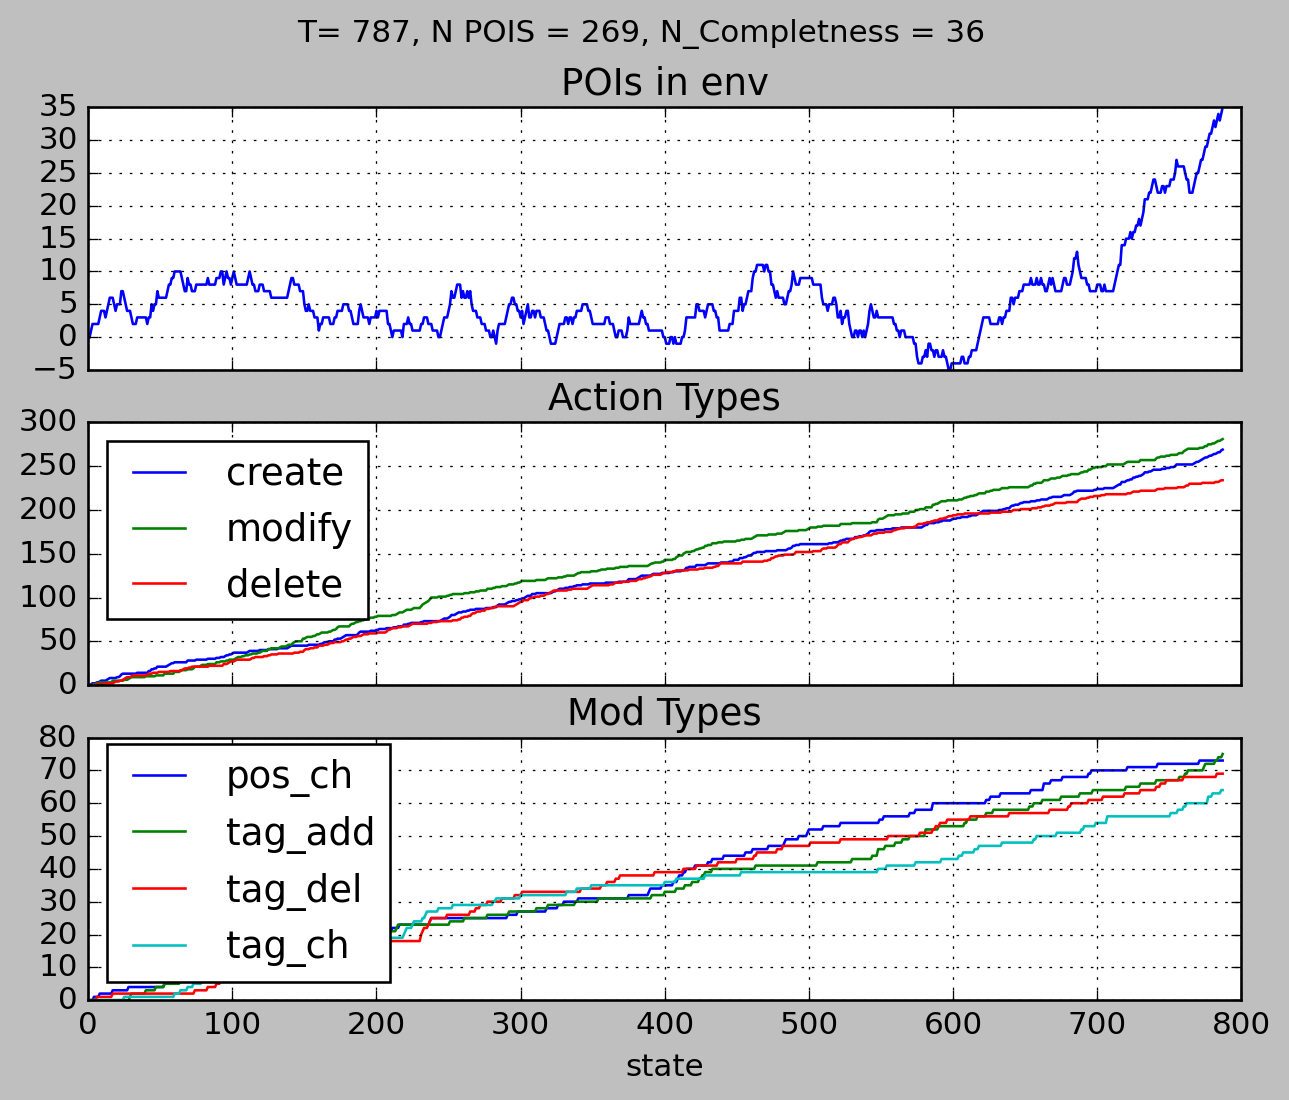

In [105]:
gdim=6
init_mappers=10
df, T, unique_pois,n_mappers = sim(
    n_mappers=init_mappers,
    new_mapper_prob=0,
    p=0.1,
    p_action = [1, 0, 0],
    p_modify = [0.25,0.25,0.25,0.25],
    s=0.15,
    grid_dim=gdim,
    stationary=False)
fig, axes = plt.subplots(ncols=1,nrows=3,sharex=True,figsize=(8,6))
(df["create"].cumsum() - df["delete"].cumsum()).plot(ax=axes[0], title="POIs in env",grid=True)
df[['create', 'modify', 'delete']].cumsum().plot(ax=axes[1], title="Action Types",grid=True)
df[['pos_ch', 'tag_add', 'tag_del', 'tag_ch']].cumsum().plot(ax=axes[2], title="Mod Types",grid=True);
plt.suptitle("T= %s, N POIS = %s, N_Completness = %s " % (T, unique_pois,gdim**2));


In [ ]:
data =[]
gdim=4

n = 100
p = 0.5
for i in range(n):
    #if i%10 == 0:
    #print(i)
    for init_mappers in [1,10]:
        for nmp in [0,0.25,0.5,0.75]:
            for spat in [0,0.25,0.5,0.75]:
                #print(init_mappers,nmp,spat)
                df_, T, n_pois,n_mappers = sim(
                n_mappers=init_mappers,
                new_mapper_prob=nmp,
                p=p,
                p_action = [1, 0, 0],
                p_modify = [0.25,0.25,0.25,0.25],
                s=spat,
                grid_dim=gdim,
                stationary=False)
                data.append(dict(s=spat,p=p,init_mappers=init_mappers,
                                 nmp=nmp,T=T,N=gdim**2,n_mappers=n_mappers,n_pois=n_pois,
                                 grid_dim=gdim))

df = pd.DataFrame(data)
del df["p"], df["N"]
dfm = df.melt(id_vars=['T', 'n_mappers', 'n_pois', 'grid_dim',"init_mappers"])

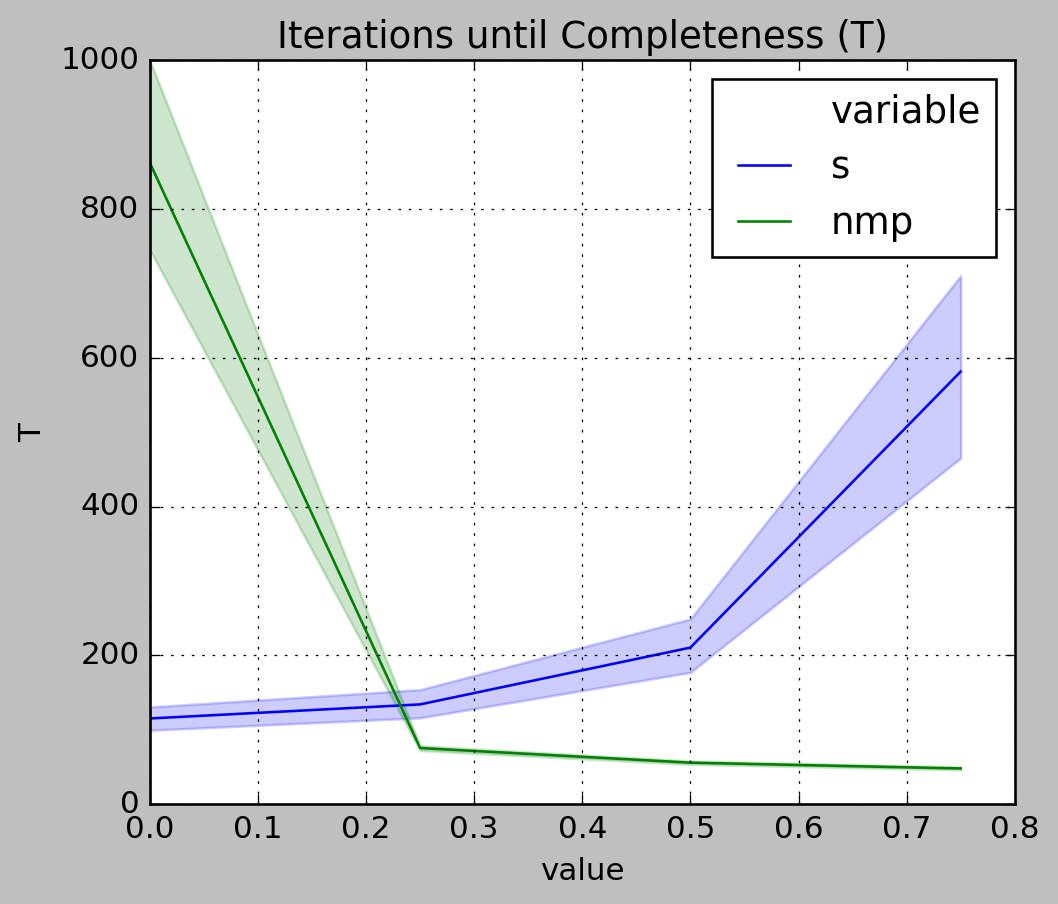

In [109]:
#fig, axes = plt.subplots(ncols=1,nrows=3,sharex=True,figsize=(7,6))
sns.lineplot(data=dfm,y="T", x="value",hue="variable");plt.title("Iterations until Completeness (T)");plt.grid()